# GERMAN POWER PRICE ANALYSIS
<b>Background</b>

You are provided with a comprehensive dataset containing German electricity market data (*Price_de* as target variable) along with fundamental supply and demand factors across European markets. 
Your task is to analyze the relationship between these fundamentals and German power prices, with particular focus on understanding price dynamics during peak hours.

**Dataset Overview**

- Target Variable: Price_de - German electricity prices
- Timeframe: ~22,000 hourly observations
- Scope: European power market fundamentals with focus on German market
**Key Fundamental Categories Available:**

Supply Side Factors:
- Conventional Generation: Coal, Gas, Lignite, Nuclear availability and generation
- Renewable Generation: Solar, Wind, Hydro across multiple countries
- Cross-border Flows: Net Transfer Capacities (NTC) between countries

Demand Side Factors:
- Power Demand: Across Germany, Netherlands, France, UK, and other European markets
- Weather Variables: Temperature data affecting both demand and renewable output

Market Indicators:
- Commodity Prices: Coal (API2), Gas (TTF, PEG, VTP, THE, PVB), Carbon (EUA)
- Generation Costs: Cost variables for different countries and fuel types

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pylab as py
import seaborn as sns


path = '../data/dataframe.csv'
df = pd.read_csv(path)

In [3]:
# Dimension Dataframe
df.shape

(21911, 96)

## PART 1: DATA EXPLORATION AND UNDERSTANDING


### **1.** Load and examine the dataset structure
    - What time period does this data cover?
    - Are there any missing values or data quality issues?
    - What is the frequency of observations?

In [4]:
print(df.head())

              reference_date  Price_de  Coal_avail_de    Demand_de  \
0  2023-09-01 00:00:00+02:00     98.90         9497.0  43502.14002   
1  2023-09-01 01:00:00+02:00     95.97         9497.0  41682.35598   
2  2023-09-01 02:00:00+02:00     93.29         9497.0  41093.58105   
3  2023-09-01 03:00:00+02:00     93.07         9497.0  41176.69539   
4  2023-09-01 04:00:00+02:00     94.08         9497.0  42085.08745   

   Gas_avail_de  Lignite_avail_de  Ntc_dkno_de  Solar_de   Temp_de   Wind_de  \
0       12327.5           12522.0          NaN      3.50  14.27045  12940.25   
1       12327.5           12522.0          NaN      2.75  14.05581  12407.25   
2       12327.5           12522.0          NaN      2.25  13.89315  11835.00   
3       12218.5           12522.0          NaN      2.25  13.71470  11182.50   
4       12218.5           12299.0          NaN      2.50  13.72212  10503.25   

   ...  Temp_east  Wind_nordic  Wind_pol  Wind_uk  Cost_de  Cost_nl  cost_fr  \
0  ...   18.38345 

In [5]:
print(df.tail())

                  reference_date  Price_de  Coal_avail_de    Demand_de  \
21906  2026-03-01 20:00:00+01:00       NaN        11252.1  53308.11652   
21907  2026-03-01 21:00:00+01:00       NaN        11252.1  51306.43508   
21908  2026-03-01 22:00:00+01:00       NaN        11252.1  50644.81810   
21909  2026-03-01 23:00:00+01:00       NaN        11252.1  48319.57747   
21910  2026-03-02 00:00:00+01:00       NaN        11252.1  46578.02932   

       Gas_avail_de  Lignite_avail_de  Ntc_dkno_de  Solar_de  Temp_de  \
21906       15659.6           14696.0  4992.500000       0.0  0.92200   
21907       15659.6           14696.0  4984.000000       0.0  0.35060   
21908       15659.6           14696.0  4990.833333       0.0 -0.00234   
21909       15659.6           14696.0  5035.500000       0.0 -0.33894   
21910       15659.6           14696.0  4660.333333       0.0 -0.57826   

           Wind_de  ...  Temp_east  Wind_nordic  Wind_pol  Wind_uk    Cost_de  \
21906  26020.33710  ...   2.650930 

In [6]:
# First of all I want to remove timezone info 

df['reference_date'] = pd.to_datetime(df['reference_date'], utc=True).dt.tz_localize(None) 
df = df.sort_values(by='reference_date') 
print(df.head())

       reference_date  Price_de  Coal_avail_de    Demand_de  Gas_avail_de  \
0 2023-08-31 22:00:00     98.90         9497.0  43502.14002       12327.5   
1 2023-08-31 23:00:00     95.97         9497.0  41682.35598       12327.5   
2 2023-09-01 00:00:00     93.29         9497.0  41093.58105       12327.5   
3 2023-09-01 01:00:00     93.07         9497.0  41176.69539       12218.5   
4 2023-09-01 02:00:00     94.08         9497.0  42085.08745       12218.5   

   Lignite_avail_de  Ntc_dkno_de  Solar_de   Temp_de   Wind_de  ...  \
0           12522.0          NaN      3.50  14.27045  12940.25  ...   
1           12522.0          NaN      2.75  14.05581  12407.25  ...   
2           12522.0          NaN      2.25  13.89315  11835.00  ...   
3           12522.0          NaN      2.25  13.71470  11182.50  ...   
4           12299.0          NaN      2.50  13.72212  10503.25  ...   

   Temp_east  Wind_nordic  Wind_pol  Wind_uk  Cost_de  Cost_nl  cost_fr  \
0   18.38345      4827.00       NaN

#### **1.1** What ime period does the data(frame) cover?

In [7]:
start_date = df['reference_date'].min()
end_date = df['reference_date'].max()
print(f"Start date: {start_date}")
print(f"End date: {end_date}")

Start date: 2023-08-31 22:00:00
End date: 2026-03-01 23:00:00


#### **1.2** Are there any missing values or data quality issues?
I present the analysis only for the target and the main covariates

In [8]:
print("German price descriptive stats:")
print(df["Price_de"].describe(),"\n")
missing_count = len(df) - df["Price_de"].count()
print(f"Number of missing values: {missing_count}")

German price descriptive stats:
count    18070.000000
mean        83.588906
std         58.810120
min       -250.320000
25%         59.070000
50%         86.355000
75%        109.307500
max       2325.830000
Name: Price_de, dtype: float64 

Number of missing values: 3841


**Price_de**-> There are 3841 missing values in Price_de that correspond to the values after '2025-09-22 23:00:00', with no other obvious data quality issues based on the descriptive statistics.

In [9]:
print("German demand descriptive stats:")
print(df["Demand_de"].describe(),"\n")
missing_count = len(df) - df["Demand_de"].count()
print(f"Number of missing values: {missing_count}")

German demand descriptive stats:
count    21911.000000
mean     53884.056990
std       9237.670080
min      33133.833090
25%      46207.874475
50%      53812.094800
75%      60654.949485
max      74884.375770
Name: Demand_de, dtype: float64 

Number of missing values: 0


**Demand_de**-> There are no missing values, with no other obvious data quality issues based on the descriptive statistics.

In [10]:
print("Solar Generation descriptive stats:")
print(df["Solar_de"].describe(),"\n")
missing_count = len(df) - df["Solar_de"].count()
print(f"Number of missing values: {missing_count}")

Solar Generation descriptive stats:
count    21911.000000
mean      7408.500242
std      11533.315115
min          0.000000
25%          5.000000
50%         89.000000
75%      11840.000000
max      52498.750000
Name: Solar_de, dtype: float64 

Number of missing values: 0


**Solar_de**-> There are no missing values, with no other obvious data quality issues based on the descriptive statistics.

In [11]:
print("Carbon cost descriptive stats:")
print(df["Cost_de"].describe(),"\n")
missing_count = len(df) - df["Cost_de"].count()
print(f"Number of missing values: {missing_count}")

Carbon cost descriptive stats:
count    21905.000000
mean       100.536748
std         14.040157
min         66.495500
25%         93.668750
50%         98.257000
75%        106.090250
max        139.361250
Name: Cost_de, dtype: float64 

Number of missing values: 6


**Cost_de**-> There are 6 missing values, with no other obvious data quality issues based on the descriptive statistics.

#### **1.3** What is the frequency of observations?

In [12]:
time_diff = df['reference_date'].diff()
print(time_diff.describe(),"\n")

count                        21910
mean     0 days 01:00:00.492925604
std      0 days 00:00:42.123273684
min                0 days 01:00:00
25%                0 days 01:00:00
50%                0 days 01:00:00
75%                0 days 01:00:00
max                0 days 02:00:00
Name: reference_date, dtype: object 



The *reference_data* has an almost consistent hourly frequency, though a maximum gap of 2 hours indicates at least one missing timestamp.

In [13]:
# Count how many time differences equal exactly 2 hours
num_two_hour_gaps = (time_diff == pd.Timedelta('2h')).sum()

print("Number of 2-hour gaps:", num_two_hour_gaps)

Number of 2-hour gaps: 3


In [14]:
# Check for missing hourly timestamps
full_range = pd.date_range(df['reference_date'].min(),
                           df['reference_date'].max(),
                           freq='h')

missing = full_range.difference(df['reference_date'])

print("Missing timestamps:")
print(missing)

Missing timestamps:
DatetimeIndex(['2023-10-29 01:00:00', '2024-10-27 01:00:00',
               '2025-10-26 01:00:00'],
              dtype='datetime64[ns]', freq=None)


The **2-hour gaps** correspond to the autumn daylight saving time transition, when clocks are set back by one hour, creating a skipped timestamp. During the spring transition, this issue does not occur since the duplicated timestamp overwrites the previous one due to the time shift.

In [15]:
# How to deal with that? i choose to interpolate the value in the missing to preserve overall trend and continuity!
# Reindex the dataframe to include all timestamps
df = df.set_index('reference_date').reindex(full_range)
# Interpolate missing values (linear ones)
df = df.interpolate(method='linear')
# Reset index if needed
df = df.reset_index().rename(columns={'index': 'reference_date'})

In [16]:
time_diff = df['reference_date'].diff()
print(time_diff.describe(),"\n")

count              21913
mean     0 days 01:00:00
std      0 days 00:00:00
min      0 days 01:00:00
25%      0 days 01:00:00
50%      0 days 01:00:00
75%      0 days 01:00:00
max      0 days 01:00:00
Name: reference_date, dtype: object 



**count=21913** --> Now we have some additional fictitious observations.

## **2. Initial price analysis**
    - Plot the German electricity price (Price_de) over time
    - What patterns do you observe in the price series?
    - Identify and describe any seasonal patterns, trends, or anomalies

#### **2.1** Plot the German electricity price (Price_de) over time

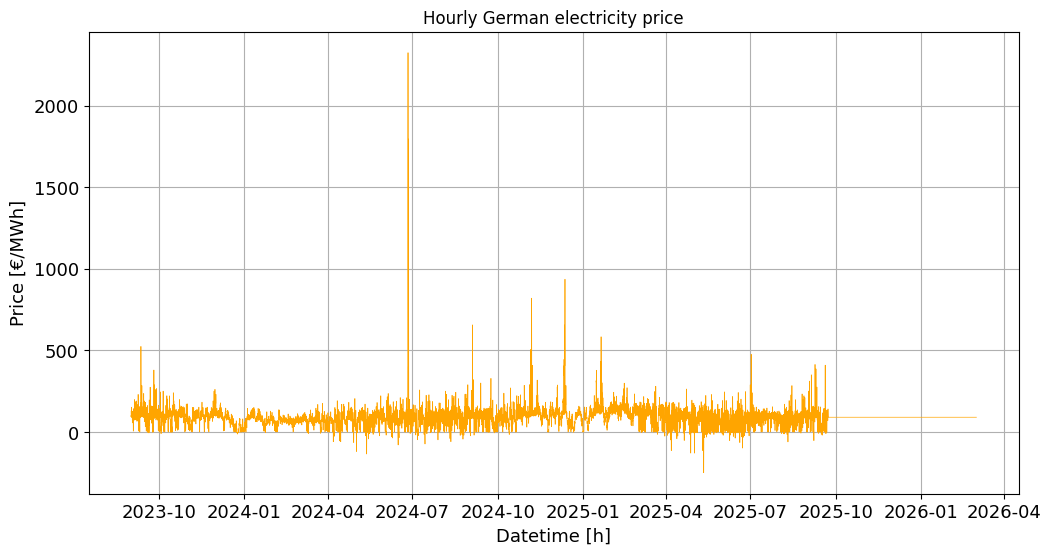

In [17]:
df.set_index('reference_date', inplace=True) # set reference_date as index to plot

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["Price_de"], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13)
ax.set_ylabel("Price [€/MWh]", fontsize=13)
plt.title("Hourly German electricity price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()


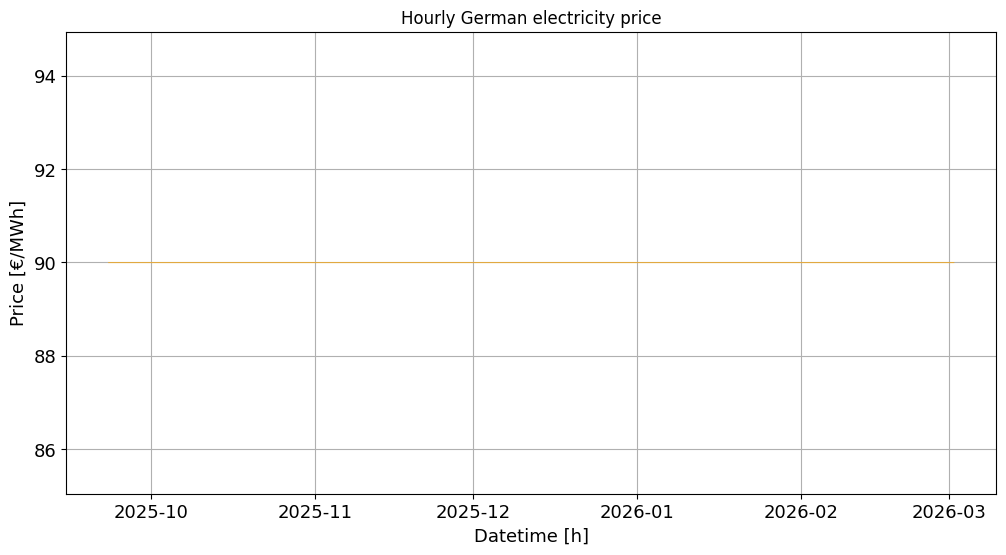

In [18]:
df_filtered = df.loc['2025-09-22 23:00:00':]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered["Price_de"], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13)
ax.set_ylabel("Price [€/MWh]", fontsize=13)
plt.title("Hourly German electricity price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

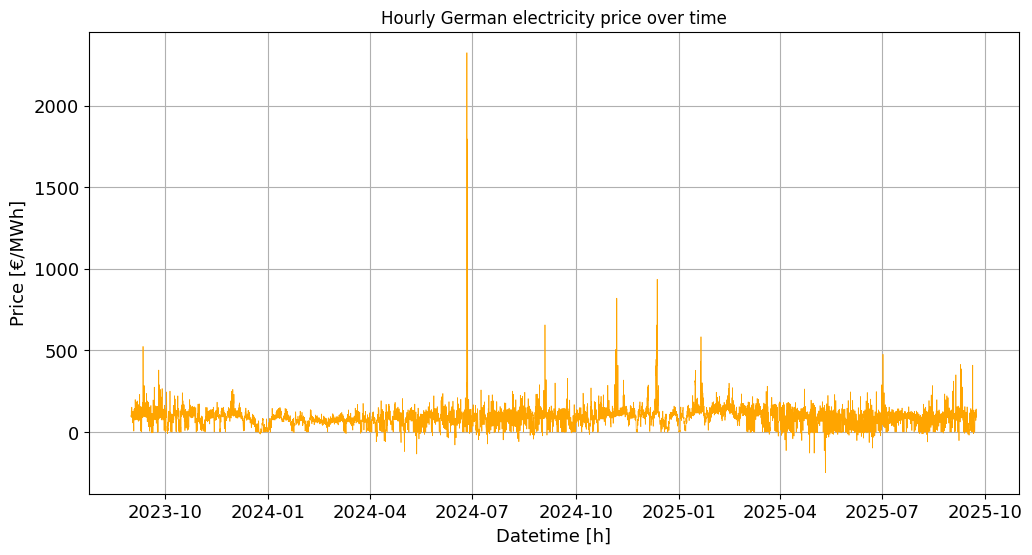

In [19]:
# filtro le date
df_filtered = df.loc[:'2025-09-22 23:00:00'] # data filtro

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered["Price_de"], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13)
ax.set_ylabel("Price [€/MWh]", fontsize=13)
plt.title("Hourly German electricity price over time")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

#### **2.2** What patterns do you observe in the price series?

<Axes: >

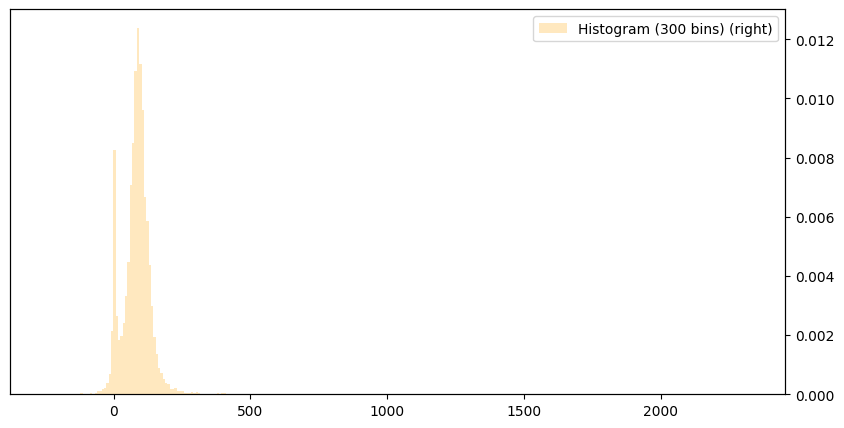

In [20]:
# Parameters
n_bins = 300  
DPI = 100  
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
df_filtered.plot(y="Price_de", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color='orange', label=f"Histogram ({n_bins} bins)",
        secondary_y=True)

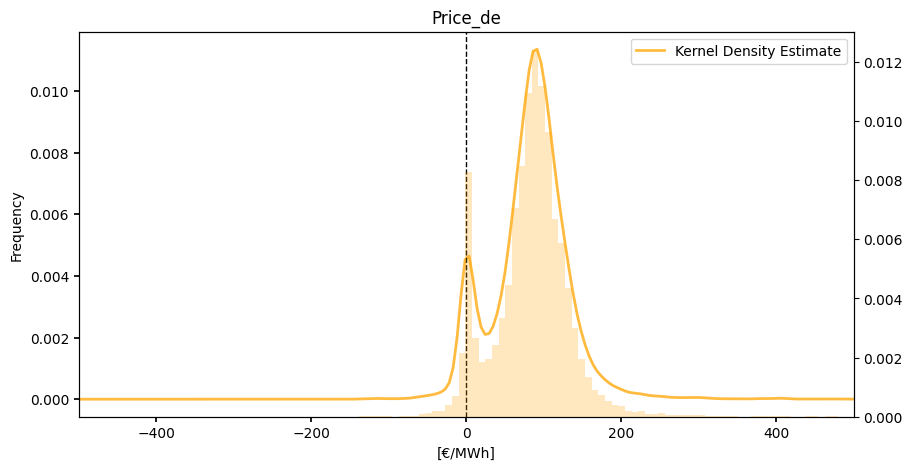

In [21]:
"""
Kernel Density Estimator provides a rational and visually pleasant representation of the data distribution
"""
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
df_filtered.plot(y="Price_de", ax=ax, kind="kde", color='orange', alpha=0.75,
        linewidth=2, label="Kernel Density Estimate")
df_filtered.plot(y="Price_de", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color='orange', label=f"Histogram ({n_bins} bins)",
        secondary_y=True)
ax.set_title("Price_de")
ax.set_xlabel("[€/MWh]")
ax.set_xlim(-500, 500)
ax.tick_params(width=1.25)
ax.axvline(0, color='black', ls='--', linewidth=1, alpha=1)
ax.legend(loc='upper right')
plt.show()

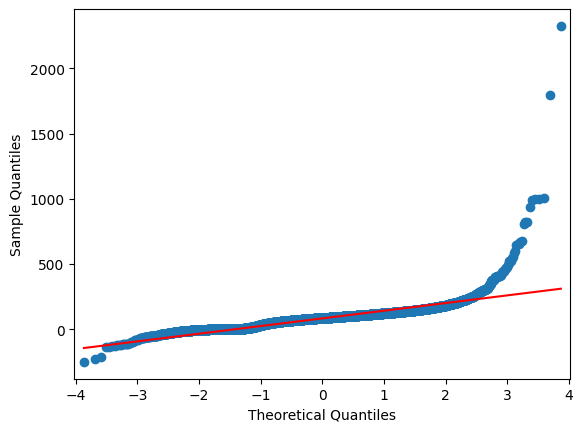

In [22]:
# QQ-plot
sm.qqplot(df_filtered["Price_de"], line='s')
py.show()

From **qq-plot** we can deduce that the distribution has big tail, expecially the positive one.

In [23]:
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(df_filtered["Price_de"], cdf="norm")
print(f"KS statistic: {ks_statistic:.3e}, p-value: {p_value:.3e}")

KS statistic: 9.062e-01, p-value: 0.000e+00



**KS Test for Normality (`Price_de`)**

- **H₀:** The data is normally distributed  
- **p-value = 0.0 → Reject H₀**  
✅ The data significantly deviates from a normal distribution.


#### **2.3** Identify and describe any seasonal patterns, trends, or anomalies

C:\Users\samue\AppData\Local\Temp\ipykernel_16408\3478534902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'hour'] = df_filtered.index.hour


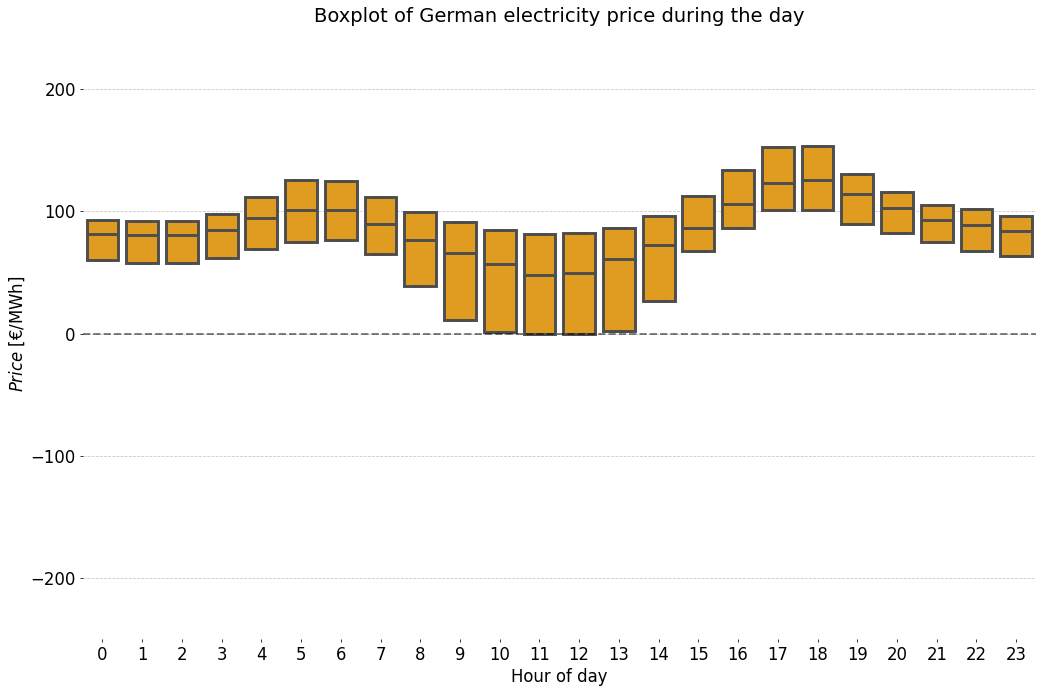

In [24]:
DPI = 70

df_filtered.loc[:, 'hour'] = df_filtered.index.hour

# Le specifiche del plot le ho riciclate dalla tesi
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)
sns.boxplot(data=df_filtered, x="hour", y="Price_de", fliersize=0, whis=0, color='orange', linewidth=3, ax=ax)
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$Price$ [€/MWh]", fontsize=17)
ax.set_title("Boxplot of German electricity price during the day", fontsize=20)
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim([-250, 250])
plt.tight_layout()
plt.show()


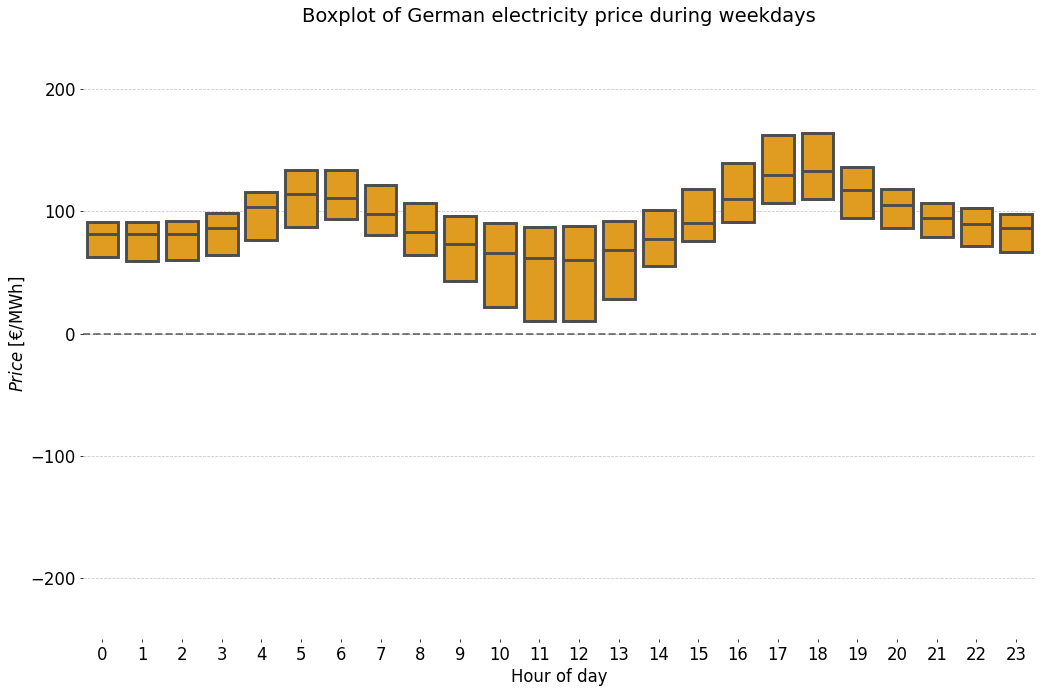

In [25]:
# Giorni lavorativi
df_filtered.loc[:, 'hour'] = df_filtered.index.hour
df_weekday = df_filtered[df_filtered.index.dayofweek.isin([0, 1, 2, 3, 4])]

fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

sns.boxplot(
    data=df_weekday,
    x="hour",
    y="Price_de",
    fliersize=0,
    whis=0,
    color='orange',
    linewidth=3,
    ax=ax
)

ax.tick_params(axis="both", which="major", labelsize=17)
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$Price$ [€/MWh]", fontsize=17)
ax.set_title("Boxplot of German electricity price during weekdays", fontsize=20)

fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

for spine in ["left", "right", "top", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.ylim([-250, 250])
plt.tight_layout()
plt.show()


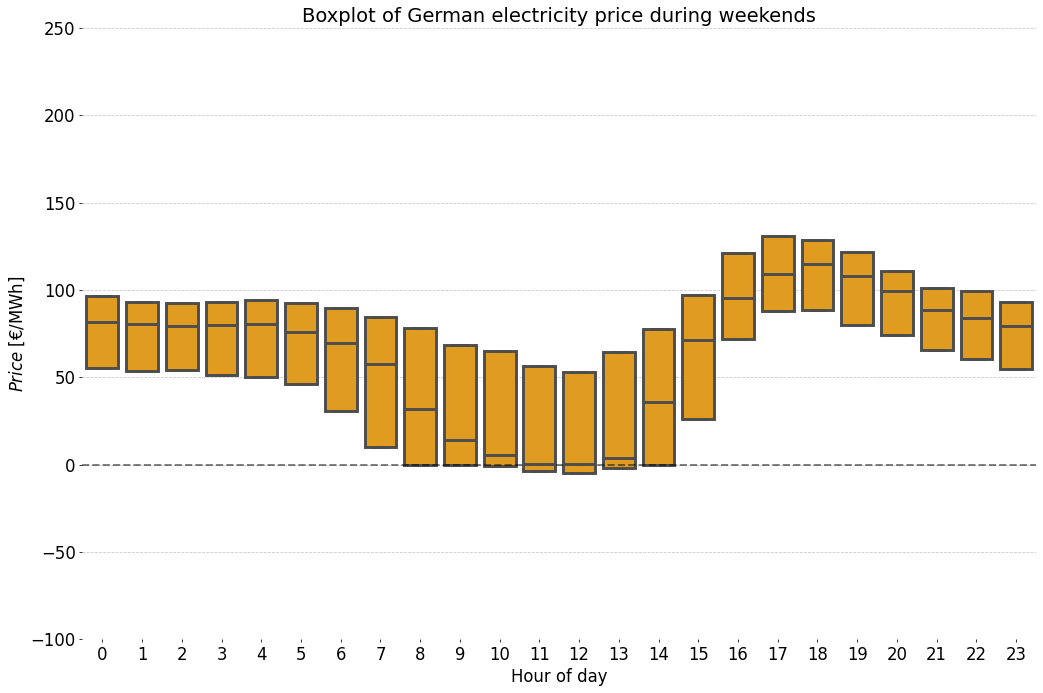

In [26]:
#Giorni nel weekend
df_filtered.loc[:, 'hour'] = df_filtered.index.hour
df_weekend = df_filtered[df_filtered.index.dayofweek.isin([5, 6])]

fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

sns.boxplot(
    data=df_weekend,
    x="hour",
    y="Price_de",
    fliersize=0,
    whis=0,
    color='orange',
    linewidth=3,
    ax=ax
)

ax.tick_params(axis="both", which="major", labelsize=17)
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$Price$ [€/MWh]", fontsize=17)
ax.set_title("Boxplot of German electricity price during weekends", fontsize=20)

fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

for spine in ["left", "right", "top", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.ylim([-100, 250])
plt.tight_layout()
plt.show()

In this way, we can provide a **NON-rigorous explanation** of the frequency diagram presented earlier.

**Price Pattern**

Prices are lowest at night and around mid-day, likely due to solar generation, and peak in the morning and evening when electricity demand is highest.

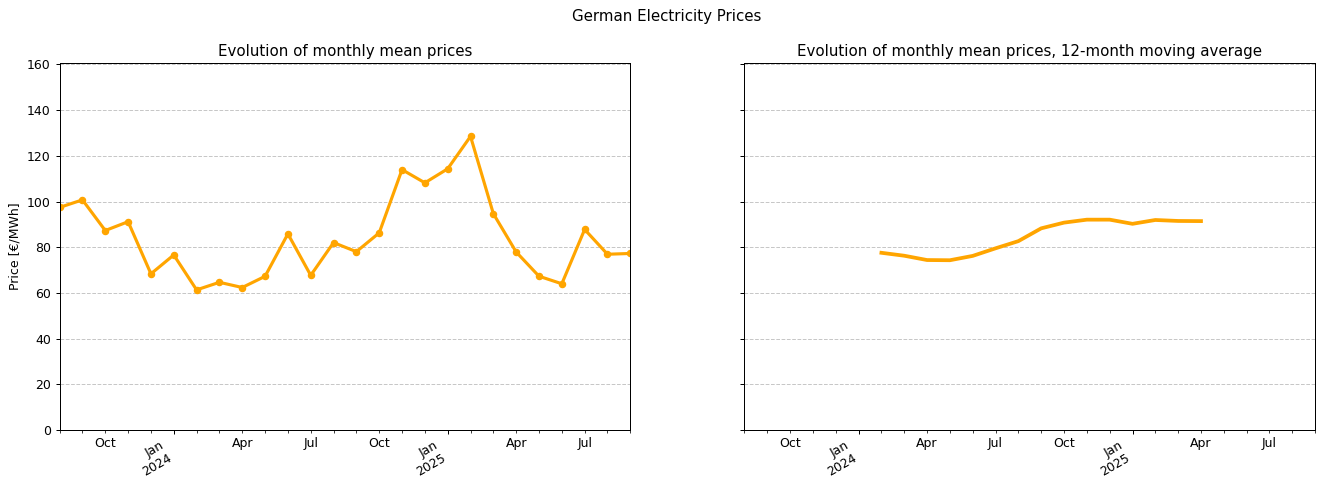

In [27]:
# Wanna try to aggregate over months
qh_price_copy = df_filtered.copy()  # or your original price DataFrame
qh_price_copy['year'] = qh_price_copy.index.year
qh_price_copy['month'] = qh_price_copy.index.month

# anche questi grafici li ho riciclati dalla tesi
agg_month_price = (
    qh_price_copy
    .groupby(by=["year", "month"])["Price_de"]
    .mean() 
)


agg_month_price.index = pd.date_range(
    start=pd.Timestamp(f"{agg_month_price.index[0][0]}-{agg_month_price.index[0][1]}"),
    end=pd.Timestamp(f"{agg_month_price.index[-1][0]}-{agg_month_price.index[-1][1]}"),
    freq="1MS"  # month start frequency
)

rolling_window = 12  # 12month rolling mean


fig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=90, sharex=True, sharey=True)

agg_month_price.plot(ax=ax[0],
                     ylabel="Price [€/MWh]",
                     c="orange",
                     linewidth=2.5,
                     title="Evolution of monthly mean prices")
agg_month_price.plot(ax=ax[0],
                     style=".",
                     color="orange",
                     markersize=10)

agg_month_price.rolling(rolling_window, center=True).mean().plot(ax=ax[1],
                                                                 ylabel="Price [€/MWh]",
                                                                 c="orange",
                                                                 linewidth=3,
                                                                 title=f"Evolution of monthly mean prices, {rolling_window}-month moving average")


plt.ylim(0, 1.25 * agg_month_price.max())


ax[0].grid(True, axis='y', linestyle='--', alpha=0.7)
ax[1].grid(True, axis='y', linestyle='--', alpha=0.7)
fig.autofmt_xdate()
fig.suptitle('German Electricity Prices')
plt.show()

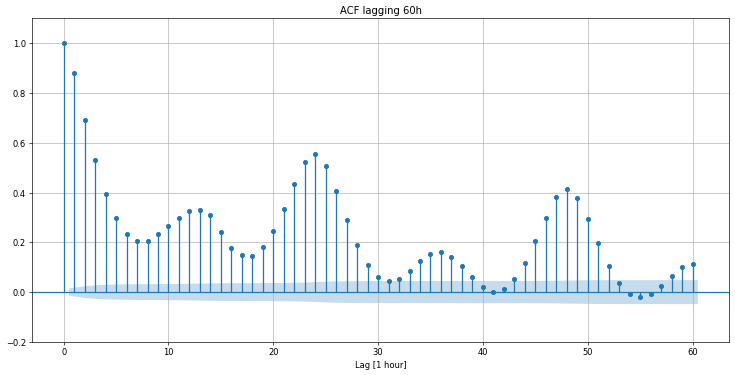

'The first ~3 lags (not considering the lag=0) have the most significant partial autocorrelation. then the lags corresponding to 24h and 48h (also 12h) show noticeable levels.'

In [28]:
# ACF: lets analyze autocorrelation in Price_de!!!!!

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(df_filtered["Price_de"], alpha=.05, lags=12*5,
                         ax=ax, title="ACF lagging 60h")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [1 hour]')
plt.grid()
plt.show()
"""Remember that autocorrelation values outside this band are statistically significant at the 5% significance level!!!!"""
"""The first ~3 lags (not considering the lag=0) have the most significant partial autocorrelation. then the lags corresponding to 24h and 48h (also 12h) show noticeable levels."""

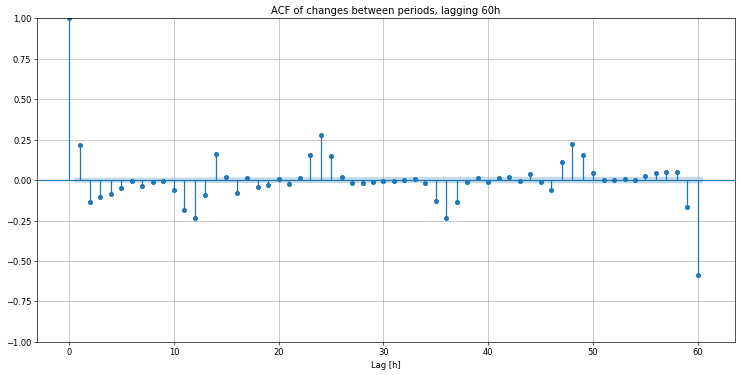

In [29]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(df_filtered["Price_de"].diff().diff(12*5).dropna(), alpha=.05, lags=60,
                         ax=ax, title="ACF of changes between periods, lagging 60h")
plt.xlabel('Lag [h]')
plt.grid()
plt.show()

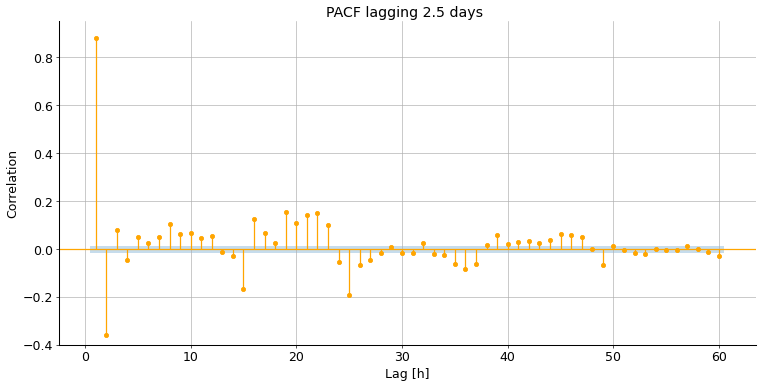

In [30]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_pacf(df_filtered["Price_de"], alpha=.05, lags=12*5, 
                         zero=False,
                         ax=ax,
                         color="orange", vlines_kwargs={"colors": "orange"})
plt.ylim(-0.4, 0.95)
# plt.xlim(-5, 4*24*2.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [h]", fontsize=15)
ax.set_title("PACF lagging 2.5 days ", fontsize=17)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("orange")
plt.grid()
plt.show()

In [31]:
#Sesonal Decomposition (Additive one since prices can be negative)
df_filtered_1 = df_filtered#.loc['2024-01-01':'2025-07-07']  Filtro un subset di date

# Ensure enough data points for decomposition
result = seasonal_decompose(df_filtered_1['Price_de'], model='additive', period=24*30, two_sided=False)

# Combine components 
ts = df_filtered_1[['Price_de']].copy()
ts['Trend'] = result.trend
ts['Seasonality'] = result.seasonal
ts['Residual'] = result.resid

with sns.axes_style('white'):
    ts.plot(
        subplots=True,
        figsize=(14, 8),
        title=['Price_de', 'Trend Component', 'Seasonal Component', 'Residuals'],
        legend=False
    )
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=0.91)
    plt.show()

NameError: name 'seasonal_decompose' is not defined

We can observe a significant trend component, while the seasonal plot is too dense to be commented. The residual look stationary, but we hold some doubts on this and i'll check better below.

**TEST ON PRICE_DE STATIONARITY**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# perform augmented Dickey-Fuller test
adf = adfuller(df_filtered["Price_de"])

print(adf)

(np.float64(-12.24741010961875), np.float64(9.712472943997458e-23), 44, 18029, {'1%': np.float64(-3.4307127617338673), '5%': np.float64(-2.8617003269713823), '10%': np.float64(-2.566855337833742)}, np.float64(164349.75484492054))


**H0: non-stationarity**

ADF statistics of -12.34 abd p-value of 9.712472943997458e-23, we strongly rejecting the null hypothesis that the timeseries is non-stationary

In [ ]:
from statsmodels.tsa.stattools import kpss

# KPSS TEST FOR STATIONARY (NEVER DO ADF ALONE!)
kpss_test = kpss(df_filtered["Price_de"], regression='c', nlags='auto')

print(kpss_test)

(np.float64(1.1485060992655791), np.float64(0.01), 61, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\samue\AppData\Local\Temp\ipykernel_18644\1437740956.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df_filtered["Price_de"], regression='c', nlags='auto')


**H0: stationarity**

- KPSS Statistic: 1.1485  
- p-value: 0.01

You reject the null hypothesis — the series Price_de is non-stationary.

**CONCLUSION**: The two statistical tests therefore output opposite results, in this case it typically means that the time series is ”difference-stationary”, and so it could require differencing to become stationary.

In [ ]:
#let's perform the tests on the diff time series
diff_series = df_filtered["Price_de"].diff().dropna()


adf_result = adfuller(diff_series)
kpss_result = kpss(diff_series, regression='c', nlags='auto')

print("ADF Test:")
print(f"Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}\n")

print("KPSS Test:")
print(f"Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
print(f"Critical Values: {kpss_result[3]}")

ADF Test:
Statistic: -30.793683216796097
p-value: 0.0
Critical Values: {'1%': np.float64(-3.430712781858862), '5%': np.float64(-2.8617003358653257), '10%': np.float64(-2.566855342567849)}

KPSS Test:
Statistic: 0.009945983744429714
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\samue\AppData\Local\Temp\ipykernel_18644\3938527815.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(diff_series, regression='c', nlags='auto')


The first difference in now stationary!

In [ ]:
# Now we check the stationarity of the 24 hourly time serires

results = []

for h in range(24):
    series = df_filtered[df_filtered['hour'] == h]['Price_de'].dropna()
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series)
    kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
    
    results.append({
        'Hour': h,
        'ADF Statistic': adf_stat,
        'ADF p-value': adf_p,
        'KPSS Statistic': kpss_stat,
        'KPSS p-value': kpss_p
    })

results_df = pd.DataFrame(results)
print(results_df)

C:\Users\samue\AppData\Local\Temp\ipykernel_18644\1076891000.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\1076891000.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\1076891000.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\10768910

    Hour  ADF Statistic   ADF p-value  KPSS Statistic  KPSS p-value
0      0      -4.218788  6.122764e-04        1.521758      0.010000
1      1      -4.339761  3.788214e-04        1.525598      0.010000
2      2      -4.322926  4.053121e-04        1.660567      0.010000
3      3      -4.955988  2.710263e-05        1.520941      0.010000
4      4     -17.026331  8.386553e-30        0.706396      0.012964
5      5      -3.584708  6.060191e-03        0.792944      0.010000
6      6      -3.265255  1.650482e-02        0.657259      0.017431
7      7      -2.795892  5.886294e-02        0.354222      0.096887
8      8      -2.493794  1.169917e-01        0.347612      0.099736
9      9      -2.444100  1.296742e-01        0.436027      0.061626
10    10      -2.397350  1.424857e-01        0.534806      0.033827
11    11      -2.250955  1.882737e-01        0.565299      0.026960
12    12      -2.230673  1.953019e-01        0.549146      0.030598
13    13      -2.255401  1.867555e-01        0.5

C:\Users\samue\AppData\Local\Temp\ipykernel_18644\1076891000.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\1076891000.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\1076891000.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\10768910

For (almost) every hour the ADF test is suggesting non-stationarity of the data, as is the KPSS.

In [ ]:
# Select series for the hour and difference it and make again the test!
results_diff = []

for h in range(24):
    
    series = df_filtered[df_filtered['hour'] == h]['Price_de'].dropna().diff().dropna()

    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series)
    kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
    
    results_diff.append({
        'Hour': h,
        'ADF Statistic': adf_stat,
        'ADF p-value': adf_p,
        'KPSS Statistic': kpss_stat,
        'KPSS p-value': kpss_p
    })

results_diff_df = pd.DataFrame(results_diff)
print(results_diff_df)

C:\Users\samue\AppData\Local\Temp\ipykernel_18644\3839830257.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\3839830257.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\3839830257.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')
C:\Users\samue\AppData\Local\Temp\ipykernel_18644\38398302

    Hour  ADF Statistic   ADF p-value  KPSS Statistic  KPSS p-value
0      0     -13.017543  2.492808e-24        0.041852      0.100000
1      1      -9.249474  1.505817e-15        0.048207      0.100000
2      2     -13.255951  8.587408e-25        0.052978      0.100000
3      3      -9.974182  2.199809e-17        0.151522      0.100000
4      4     -10.442052  1.513096e-18        0.074738      0.100000
5      5     -10.342698  2.659630e-18        0.058208      0.100000
6      6      -8.706520  3.687594e-14        0.077232      0.100000
7      7      -8.232478  6.011080e-13        0.093770      0.100000
8      8      -8.220436  6.451565e-13        0.101117      0.100000
9      9      -8.236074  5.885454e-13        0.064813      0.100000
10    10      -8.215193  6.653254e-13        0.063431      0.100000
11    11      -8.313021  3.744516e-13        0.070060      0.100000
12    12      -8.308682  3.841277e-13        0.071935      0.100000
13    13      -8.210155  6.852997e-13        0.0

C:\Users\samue\AppData\Local\Temp\ipykernel_18644\3839830257.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags='auto')


For all the differenced time series the stationarity hypothesis can now be accepted. Therefore, if we work with a framework that builds independent models for each hour of the day, we will then probably need to perform differencing on the target variable, prior to forecasting. On the other hand, when building models that do no split the price time series, or neural networks models, which do not need the stationarity assumption, we will probably not need differencing.